In [ ]:
import torch
import tiktoken
import matplotlib
from torch import nn

In [ ]:
CFG = {
    'vocab_size':50257,
    'context_length':1024,
    'emb_dim':768,
    'layer_num':12,
    'head_num':12,
    'drop_rate':0.1,
    'bias':False,
}

In [ ]:
class DumpLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-05) -> None:
        super().__init__()
    
    def forward(self, x):
        return x
    
class DumpTransformerBlock(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()

    def forward(self, x):
        return x
    

class DumpGptModel(nn.Module):
    def __init__(self, cfg) -> None:
        super().__init__()

        self.emb_tok = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.emb_pos = nn.Embedding(cfg['context_length'], cfg['emb_dim'])

        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.tr_blocks = nn.Sequential(*[DumpTransformerBlock() for _ in range(cfg['layer_num'])])

        self.fi_norm =  DumpLayerNorm(cfg['emb_dim'])

        self.out_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)

    def forward(self,x):
        batch_len,seq_len = x.shape

        tok_emb = self.emb_tok(x)
        pos_emb = self.emb_pos(torch.arange(seq_len))

        x = tok_emb + pos_emb
        x = self.drop_emb(x)

        x = self.tr_blocks(x)
        x = self.fi_norm(x)

        logits = self.out_head(x)

        return logits


In [ ]:
tokenizer = tiktoken.get_encoding('gpt2')

batch = []

txt1 =  "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch,dim=0)
batch

In [ ]:
torch.manual_seed(123)

m = DumpGptModel(CFG)

m(batch)

In [ ]:
torch.manual_seed(123)

batch_ex = torch.rand(2,5)
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())

out = layer(batch_ex)

print(out)

In [ ]:
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1,keepdim=True)

print(mean,var)

In [ ]:
out_norm = (out-mean) / torch.sqrt(var)

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-05) -> None:
        super().__init__()
        self.eps = eps

        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))


    def forward(self,x):
        mean = torch.mean(x,dim=-1,keepdim=True)
        var = torch.var(x,dim=-1,keepdim=True,unbiased=False)
        norm = (x-mean) / torch.sqrt(var+self.eps)

        return norm * self.scale + self.shift

In [ ]:
layer_norm = LayerNorm(5)

out_ln = layer_norm(batch_ex)

print(out_ln)

mean = torch.mean(out_ln,dim=-1,keepdim=True)
var = torch.var(out_ln,dim=-1,keepdim=True,unbiased=False)

print(mean,var)

In [112]:
class LayerGelu(nn.Module):
    def __init__(self) -> None:
        super().__init__()


    def forward(self,x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

tensor([-3.0000, -2.9394, -2.8788, -2.8182, -2.7576, -2.6970, -2.6364, -2.5758,
        -2.5152, -2.4545, -2.3939, -2.3333, -2.2727, -2.2121, -2.1515, -2.0909,
        -2.0303, -1.9697, -1.9091, -1.8485, -1.7879, -1.7273, -1.6667, -1.6061,
        -1.5455, -1.4848, -1.4242, -1.3636, -1.3030, -1.2424, -1.1818, -1.1212,
        -1.0606, -1.0000, -0.9394, -0.8788, -0.8182, -0.7576, -0.6970, -0.6364,
        -0.5758, -0.5152, -0.4545, -0.3939, -0.3333, -0.2727, -0.2121, -0.1515,
        -0.0909, -0.0303,  0.0303,  0.0909,  0.1515,  0.2121,  0.2727,  0.3333,
         0.3939,  0.4545,  0.5152,  0.5758,  0.6364,  0.6970,  0.7576,  0.8182,
         0.8788,  0.9394,  1.0000,  1.0606,  1.1212,  1.1818,  1.2424,  1.3030,
         1.3636,  1.4242,  1.4848,  1.5455,  1.6061,  1.6667,  1.7273,  1.7879,
         1.8485,  1.9091,  1.9697,  2.0303,  2.0909,  2.1515,  2.2121,  2.2727,
         2.3333,  2.3939,  2.4545,  2.5152,  2.5758,  2.6364,  2.6970,  2.7576,
         2.8182,  2.8788,  2.9394,  3.00

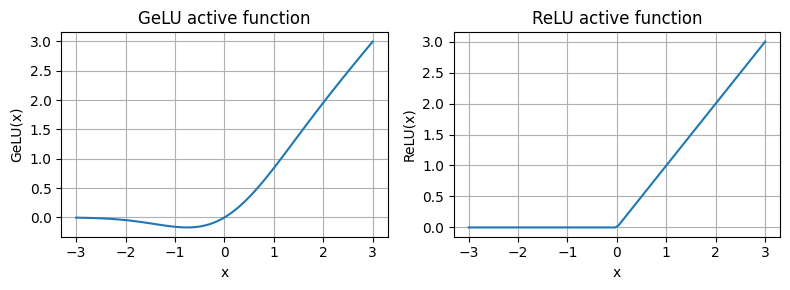

In [113]:
import matplotlib.pyplot as plt

gelu,relu = LayerGelu(),nn.ReLU()

x = torch.linspace(-3,3,100)

y_gelu,y_relu = gelu(x),relu(x)

print(x,y_gelu,y_relu)

plt.figure(figsize=(8,3))

for i,(y,label) in enumerate(zip([y_gelu,y_relu],['GeLU','ReLU']),1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} active function")
    plt.xlabel('x')
    plt.ylabel(f'{label}(x)')
    plt.grid(True)


plt.tight_layout()
plt.show()

In [114]:
class FeedForward(nn.Module):
    def __init__(self,cfg) -> None:
        super().__init__()

        emb_dim = cfg['emb_dim']
        self.layer = nn.Sequential(nn.Linear(emb_dim,4*emb_dim),
                                   LayerGelu(),
                                   nn.Linear(4*emb_dim,emb_dim),
                                   )
    
    def forward(self,x):
        return self.layer(x)

In [115]:
ffn = FeedForward(CFG)

x = torch.rand(2,1024,768)

out = ffn(x)

print(out.shape
      ,out)

torch.Size([2, 1024, 768]) tensor([[[-0.1092, -0.1405,  0.0041,  ..., -0.0797, -0.1141,  0.1044],
         [-0.0167, -0.2262,  0.0520,  ..., -0.0232, -0.0459,  0.0831],
         [-0.0425, -0.1958, -0.0438,  ..., -0.0079, -0.1721,  0.2031],
         ...,
         [-0.0966, -0.0771, -0.0649,  ...,  0.0245, -0.0949,  0.0923],
         [ 0.0549, -0.0923,  0.0464,  ...,  0.0302, -0.1289,  0.1296],
         [-0.0553, -0.1547, -0.0645,  ...,  0.0261, -0.0724,  0.0822]],

        [[-0.0424, -0.1713,  0.0281,  ...,  0.0490, -0.1166,  0.0773],
         [ 0.0100, -0.1707, -0.0486,  ...,  0.0428, -0.0627,  0.0908],
         [-0.0250, -0.0895,  0.0299,  ...,  0.0588, -0.1800,  0.0820],
         ...,
         [-0.0530, -0.1211, -0.0815,  ..., -0.0580, -0.0410,  0.0344],
         [ 0.0432, -0.0870, -0.0848,  ...,  0.0070, -0.0698,  0.0265],
         [ 0.0536, -0.1394, -0.0642,  ..., -0.0568,  0.0376,  0.1260]]],
       grad_fn=<ViewBackward0>)


In [116]:
class ExampleNN(nn.Module):
    def __init__(self,layer_size,use_shortcut = True):
        super().__init__()

        self.layers = nn.ModuleList(
            [
                nn.Sequential(nn.Linear(layer_size[i],layer_size[i+1]),nn.ReLU())
                for i in range(len(layer_size)-1)
            ]
        )

        self.use_shortcut = use_shortcut
        
    def forward(self,x):
        for layer in self.layers:
            layer_out = layer(x)
            if self.use_shortcut and x.shape == layer_out.shape:
                x = layer_out + x
            else:
                x = layer_out
                
        return x


In [117]:
def print_grad(model,x):
    output = model(x)
    taget = torch.tensor([[0.0]])

    loss = nn.MSELoss()
    loss = loss(output,taget)

    loss.backward()

    for name,param in model.named_parameters():
        if 'weight' in name:
            # print(param.grad)

            print(f"{name} has grad mean of {param.grad.abs().mean().item()}")

In [118]:
layer_size = [3,3,3,3,3,1]

sample_input = torch.tensor([[1.,0.,-1.]])

torch.manual_seed(123)

model_without_sh = ExampleNN(layer_size,False)

print_grad(model_without_sh,sample_input)

torch.manual_seed(123)

model_sh = ExampleNN(layer_size,True)

print_grad(model_sh,sample_input)

layers.0.0.weight has grad mean of 0.0006875665276311338
layers.1.0.weight has grad mean of 0.0019083978841081262
layers.2.0.weight has grad mean of 0.0038205471355468035
layers.3.0.weight has grad mean of 0.0038610314950346947
layers.4.0.weight has grad mean of 0.02481495402753353
layers.0.0.weight has grad mean of 0.5557742714881897
layers.1.0.weight has grad mean of 0.09135337918996811
layers.2.0.weight has grad mean of 0.7913904190063477
layers.3.0.weight has grad mean of 0.21711303293704987
layers.4.0.weight has grad mean of 3.140749216079712


In [ ]:
%run learn_2.ipynb

In [119]:
sa = MultiHeadAtt(2,6,3,2)

CFG = {
    'vocab_size':50257,
    'context_length':1024,
    'emb_dim':768,
    'layer_num':12,
    'head_num':12,
    'drop_rate':0.1,
    'bias':False,
}

class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()

        self.att = MultiHeadAtt(cfg['head_num'],
                                cfg['context_length'],
                                cfg['emb_dim'],
                                cfg['emb_dim'],
                                cfg['bias'],
                                cfg['drop_rate'])
        
        self.ffn = FeedForward(cfg)

        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])

        self.drop = nn.Dropout(cfg['drop_rate'])

    def forward(self,x):
        shortcut = x

        x = self.norm1(x)
        x = self.att(x)
        x = self.drop(x)

        x = shortcut + x

        shortcut = x

        x = self.norm2(x)
        x = self.ffn(x)
        x = self.drop(x)

        x = shortcut + x

        return x



In [120]:
block = TransformerBlock(CFG)

x = torch.rand(2,1024,768)

x = block(x)

x.shape

torch.Size([2, 1024, 768])

In [130]:
CFG = {
    'vocab_size':50257,
    'context_length':1024,
    'emb_dim':768,
    'layer_num':12,
    'head_num':12,
    'drop_rate':0.1,
    'bias':False,
}

class GptModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()

        self.emb_tok = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
        self.emb_pos = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
        self.emb_drop = nn.Dropout(cfg['drop_rate'])

        self.tr_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['layer_num'])])

        self.fn_norm = LayerNorm(cfg['emb_dim'])

        self.out_vec = nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)

    
    def forward(self,x):
        _,seq_len = x.shape
        tok = self.emb_tok(x)
        pos = self.emb_pos(torch.arange(seq_len,device=x.device))


        x = tok + pos
        x = self.emb_drop(x)

        x = self.tr_blocks(x)

        x = self.fn_norm(x)

        return self.out_vec(x)
        

In [125]:
torch.manual_seed(123)

mode = GptModel(CFG)

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

print(batch)

out = mode(batch)

print(out)
print(out.shape)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
torch.Size([2, 4, 768])
tensor([[[ 3.6126e-01,  4.2225e-01, -7.1129e-02,  ...,  3.4830e-01,
           4.6611e-01, -2.8378e-01],
         [-1.8588e-01, -5.5515e-01, -9.3137e-01,  ...,  6.4539e-02,
           5.7467e-01, -3.5581e-01],
         [ 7.3162e-01,  2.1609e-02,  4.8252e-02,  ...,  9.5416e-02,
          -4.5359e-01, -1.8281e-01],
         [-9.6031e-01,  4.3047e-01, -1.5453e-01,  ...,  7.7895e-01,
           4.1090e-01, -1.2484e-04]],

        [[-2.5640e-01,  9.0026e-02,  3.3531e-02,  ...,  2.6592e-01,
           4.4538e-01, -6.8056e-01],
         [ 1.1533e-01,  4.0725e-01, -1.8094e-01,  ...,  7.8006e-01,
           2.3187e-01,  2.2598e-01],
         [ 1.0501e+00,  1.0653e+00, -2.5768e-01,  ...,  6.5044e-01,
           2.9796e-01, -2.8317e-01],
         [-1.2929e-01,  4.2385e-01,  2.5976e-01,  ...,  1.2889e+00,
          -2.3878e-01,  8.8656e-02]]], grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 50257])


In [126]:
total_params = sum(p.numel() for p in mode.parameters())

print(total_params)

163009536


In [132]:
def gen_text_simp(model,idx,max_new_token,context_size):
    for i in range(max_new_token):
        input_ids = idx[:,-context_size:]

        with torch.no_grad():
            out = model(input_ids)
        
        logits = out[:,-1,:]

        prob = torch.softmax(logits,dim=-1)

        idx_next = torch.argmax(prob,dim=-1,keepdim=True)

        idx = torch.cat((idx,idx_next),dim=1)

    return idx

In [133]:
start_cn = "Hello, I am"

encoded = tokenizer.encode(start_cn)

print(encoded)

idx = torch.tensor(encoded).unsqueeze(0)

print(idx)

out = gen_text_simp(mode,idx,5,1000)

out

[15496, 11, 314, 716]
tensor([[15496,    11,   314,   716]])
torch.Size([1, 4, 768])
torch.Size([1, 5, 768])
torch.Size([1, 6, 768])
torch.Size([1, 7, 768])
torch.Size([1, 8, 768])


tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 26944]])

In [136]:
tokenizer.decode(out.squeeze(0).tolist())

'Hello, I am Featureiman Byeswick Lap'